In [1]:
import os
import sys
# modules=['NiaEnv/2022a', 'python/3.9.10', 'gcc/11.3.0', 'fftw/3.3.10']
# for mod in modules:
#     os.system("module --ignore_cache load "+mod)
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
# from albatros_analysis.src.correlations import correlations as cr
import numba as nb
import time
from scipy import linalg
#from scio import scio
from scipy import stats

BDC is using numpy


In [2]:
T_SPECTRA = 4096/250e6
print(250*10**6/4096)

61035.15625


In [3]:
@nb.njit()
def get_common_rows(specnum0,specnum1,idxstart0,idxstart1):
    nrows0,nrows1=specnum0.shape[0],specnum1.shape[0]
    maxrows=min(nrows0,nrows1)
    rownums0=np.empty(maxrows,dtype='int64')
    rownums0[:]=-1
    rownums1=rownums0.copy()
    rowidx=rownums0.copy()
    i=0;j=0;row_count=0;
    while i<nrows0 and j<nrows1:
        if (specnum0[i]-idxstart0)==(specnum1[j]-idxstart1):
            rownums0[row_count]=i
            rownums1[row_count]=j
            rowidx[row_count]=specnum0[i]-idxstart0
            i+=1
            j+=1
            row_count+=1
        elif (specnum0[i]-idxstart0)>(specnum1[j]-idxstart1):
            j+=1
        else:
            i+=1
    return row_count,rownums0,rownums1,rowidx

@nb.njit(parallel=True)
def avg_xcorr_4bit_2ant_float(pol0,pol1,specnum0,specnum1,idxstart0,idxstart1,delay=None,freqs=None):
    row_count,rownums0,rownums1,rowidx=get_common_rows(specnum0,specnum1,idxstart0,idxstart1)
    ncols=pol0.shape[1]
#     print("ncols",ncols)
    assert pol0.shape[1]==pol1.shape[1]
    xcorr=np.zeros((row_count,ncols),dtype='complex64') # in the dev_gen_phases branch
    if delay is not None:
        for i in nb.prange(row_count):
            for j in range(ncols):
                xcorr[i,j] = pol0[rownums0[i],j]*np.conj(pol1[rownums1[i],j]*np.exp(2j*np.pi*delay[rowidx[i]]*freqs[j]))
    else:
        for i in nb.prange(row_count):
            xcorr[i,:] = pol0[rownums0[i],:]*np.conj(pol1[rownums1[i],:])
    return xcorr

def get_coarse_xcorr(f1, f2, Npfb=4096):
    if len(f1.shape) == 1:
        f1 = f1.reshape(-1, 1)
    if len(f2.shape) == 1:
        f2 = f2.reshape(-1, 1)
    chans = f1.shape[1]
    Nsmall = f1.shape[0]
    wt = np.zeros(2 * Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt) * np.conj(np.fft.rfft(wt)))
#     print(n_avg)
#     n_avg[Nsmall] = np.nan
#     print(n_avg[Nsmall-10:Nsmall+10])
    n_avg = np.tile(n_avg, chans).reshape(chans, 2*Nsmall)
#     print(n_avg.shape)
    bigf1 = np.vstack([f1, np.zeros(f1.shape, dtype=f1.dtype)])
    bigf2 = np.vstack([f2, np.zeros(f2.shape, dtype=f2.dtype)])
    bigf1 = bigf1.T.copy()
    bigf2 = bigf2.T.copy()
    bigf1f = np.fft.fft(bigf1,axis=1)
    bigf2f = np.fft.fft(bigf2,axis=1)
    xx = bigf1f * np.conj(bigf2f)
    xcorr = np.fft.ifft(xx,axis=1)
    xcorr = xcorr / n_avg
    xcorr[:,Nsmall] = np.nan
    return xcorr


In [43]:
''''Here we set up the files and alignment

idx_correction is hard coded. Use satellite_detection script to get general time offset (I think?)

use "get_init_info" to get the files and spectrum numbers needed for our time interval

find the 
1834 and 1852 are presumably the range of channels we find sats in
also careful with actual channel frequency and channel index. These are indices
'''

#set start and end times. here, it's an hour of total data
t_start = 1721800002 + 5*1000
print(t_start)
t_end = t_start+3600

#use "get_init_info" to get the files and spectrum numbers needed for our time interval
a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"
files_a1, idx1 = butils.get_init_info(t_start, t_end, a1_path)
files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)
print("old idx", idx1, idx2)

#QUESTION: is this index correction found via satellite time offset script?
idx_correction=109993-100000

if idx_correction>0:
    idx1+=idx_correction
else:
    idx2+=np.abs(idx_correction)
print("new idx", idx1, idx2)

#get channel indices between 1834 and 1854, where we think we will find satellites
channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]
#total number of channels
nchans=chanend-chanstart 

#set the accumulation length for chunks (how many spectra per chunk)
acclen=30000
#time taken for one full chunk 
T_ACCLEN = acclen*4096/250e6 
#how many total chunks for the time interval we care about
nchunks = int((t_end-t_start)/T_ACCLEN)

1721805002
old idx 1770020 793457
new idx 1780013 793457
Not reading any data
245.76000000000002


In [5]:
#get our basebanditerator object for both antenna, using information from above

ant1=bdc.BasebandFileIterator(files_a1, 0, idx1, acclen, nchunks=nchunks, chanstart=chanstart, chanend=chanend, type='float')
ant2=bdc.BasebandFileIterator(files_a2, 0, idx2, acclen, nchunks=nchunks, chanstart=chanstart, chanend=chanend, type='float')

ACCLEN RECEIVED IS 30000
took 0.220 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721804973.raw
START SPECNUM IS 1294978843 obj start at 1293198830
ACCLEN RECEIVED IS 30000
took 1.402 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721804989.raw
START SPECNUM IS 1351222502 obj start at 1350429045


In [7]:
print(chanend,chanstart,nchans,acclen,nchunks)
print(nchans)

90 72 18 30000 7324
18


In [8]:
'''
Here we use the chunk-by-chunk reading method

Want to make sure that there isn't too much data missing per chunk
Skip those that aren't at least 90% complete
'''

#the chunk-by-chunk reading method. make sure that not too much data is missing
p0_a1 = np.zeros((acclen, nchans), dtype="complex128") #remember that BDC returns complex64. wanna do phase-centering in 128.
p0_a2 = np.zeros((acclen, nchans), dtype="complex128")
a1_start = ant1.spec_num_start
a2_start = ant2.spec_num_start
for i, (chunk1, chunk2) in enumerate(zip(ant1, ant2)):
    perc_missing_a1 = (1 - len(chunk1["specnums"]) / acclen) * 100
    perc_missing_a2 = (1 - len(chunk2["specnums"]) / acclen) * 100
    print("missing a1", perc_missing_a1, "missing a2", perc_missing_a2)
    if perc_missing_a1 > 10 or perc_missing_a2 > 10:
        a1_start = ant1.spec_num_start
        a2_start = ant2.spec_num_start
        print("skipping")
        continue
    print(chunk1["specnums"] - a1_start)
    outils.make_continuous(
        p0_a1, chunk1["pol0"], chunk1["specnums"] - a1_start
    )
    outils.make_continuous(
        p0_a2, chunk2["pol0"], chunk2["specnums"] - a2_start
    )
    break

missing a1 0.0 missing a2 0.0
[    0     1     2 ... 29997 29998 29999]


In [9]:
print(chanend-chanstart, nchunks, acclen)

18 7324 30000


In [10]:
#take the shifted fft of the coarse xcorr of p0_a1 and p0_a2
#this is an 18xwhatever array, where each row is a channel, and each column is the frequency intensity
#what we mean by shifted is the zero frequency is in the middle, and ascending frequency values

xc=np.fft.fftshift(get_coarse_xcorr(p0_a1,p0_a2),axes=1)

#so the coarse cross correlation is really just an array of channels with complex corr vals
xc.shape

(18, 60000)

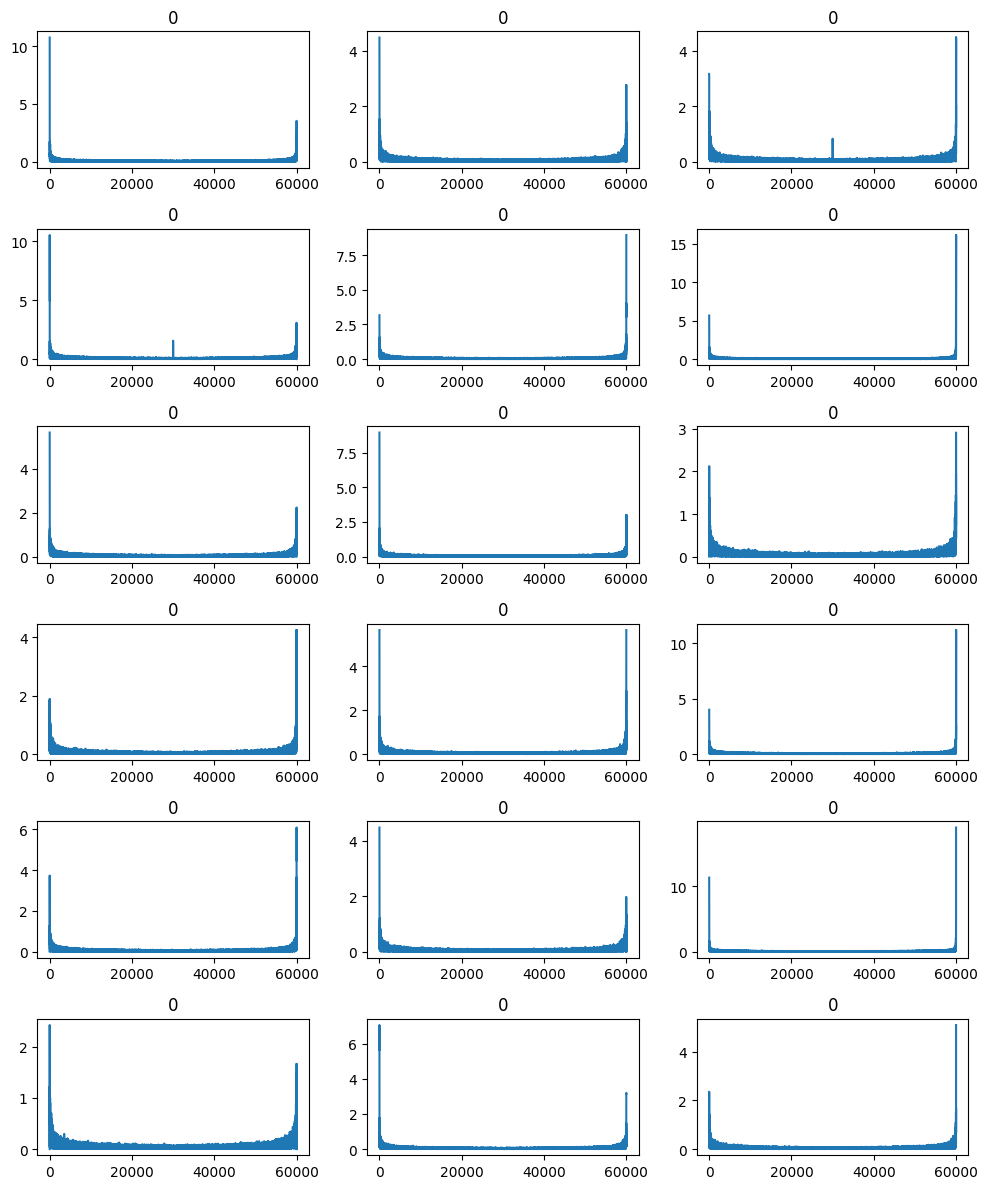

In [11]:
'''
Here we plot all of the channels we are looking at
The title is the frequency with max correlation (I think?) highest peak visually

So the only really clear ones are 109993, in subsequent channels

Note that the figure x-axis has center at 3 million, as this is the zero frequency
We only look at the 100 000 closest.
'''

center= acclen
dN= 100000
fig,ax=plt.subplots(6,3)
fig.set_size_inches(10,12)
ax=ax.flatten()
for cc in range(nchans):
    mm=np.argmax(np.abs(xc[cc,center-dN:center+dN]))
    ax[cc].set_title(f"{mm}")
    ax[cc].plot(np.abs(xc[cc,center-dN:center+dN]))
plt.tight_layout()

(-200.0, 200.0)

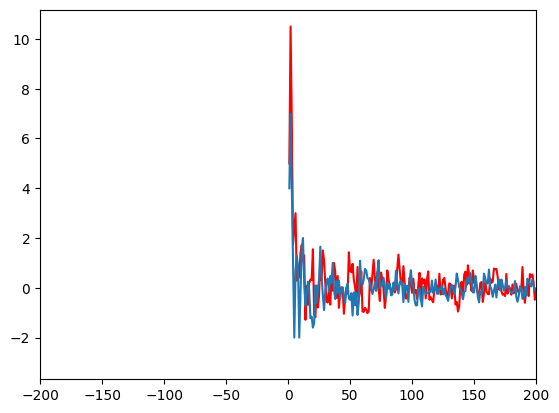

In [12]:
cc=3
mm=np.argmax(np.abs(xc[cc,center-dN:center+dN]))
plt.plot(np.real(xc[cc,center-dN:center+dN]), color='r')
plt.plot(np.real(xc[16,center-dN:center+dN]))

plt.xlim(mm-200,mm+200)

In [13]:
#where are the extra terms from in the frequency calculation?
#what exactly is going on with the ft back? reason for it?
outils.chan2freq(np.arange(1834,1834+18),alias=True)/1e6 - 0.061/2

array([138.03102344, 137.96998828, 137.90895313, 137.84791797,
       137.78688281, 137.72584766, 137.6648125 , 137.60377734,
       137.54274219, 137.48170703, 137.42067188, 137.35963672,
       137.29860156, 137.23756641, 137.17653125, 137.11549609,
       137.05446094, 136.99342578])

Text(0.5, 0, 'units of 0.3 Hz')

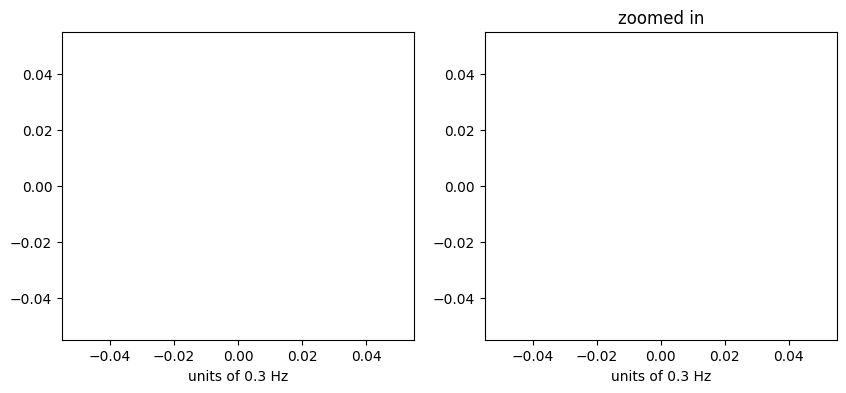

In [14]:
spec=np.fft.fft(xc[3,center-dN:center+dN])
f=plt.gcf()
f.set_size_inches(10,4)
plt.subplot(121)
plt.plot(np.abs(spec))
plt.xlabel("units of 0.3 Hz")
plt.subplot(122)
plt.title("zoomed in")
plt.plot(np.abs(spec)[79000:80000])
plt.xlabel("units of 0.3 Hz")

In [15]:
a1_coords = [79+25.031/60, -90-46.041/60, 189]  # MARS 1
a2_coords = [79+25.033/60, -90-45.531/60, 176]  # MARS 2
print(a1_coords)
tle_path = outils.get_tle_file(1721800002, "/project/s/sievers/mohanagr/OCOMM_TLES")
rsats = outils.get_risen_sats(tle_path, a1_coords, 1721800002, dt=5, niter=3600*24//5,altitude_cutoff=15)


[79.41718333333333, -90.76735, 189]
Starting Time of 1721800002 with a dt of 5


Text(0.5, 0, 'sec')

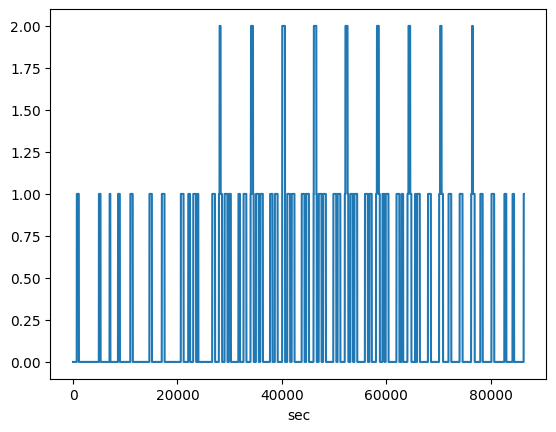

In [16]:
#a plot of how many satellites are risen 

#this gives a list of how many satellites are risen, where each entry represents a time interval
num_sats_risen = [len(x) for x in rsats]
#then you just plot it, noting that we have to multiply by 5 since that is our "dt" for the get_risen_sats
#i.e. the rate at which we measure how many sats there are
plt.plot(np.arange(len(rsats))*5,num_sats_risen)
plt.xlabel("sec")
#plt.xlim(0,20000)

(0.0, 10000.0)

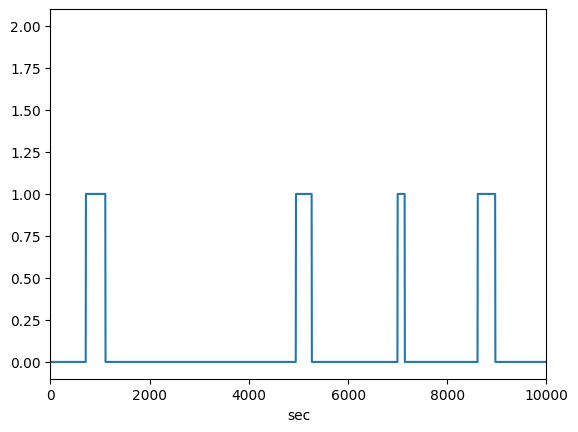

In [17]:
'''
same plot, but zoomed in
this is where he gets the 5*1000 initial timestamp from, because for the first chunk 
(which he uses to find the satellite offset) there is guaranteed to be only one satellite risen
you can clearly see this for the 5000 seconds (past 1721800002)
'''
num_sats_risen = [len(x) for x in rsats]
plt.plot(np.arange(len(rsats))*5,num_sats_risen)
plt.xlabel("sec")
plt.xlim(0,10000)

14.166666666666666 18.081818181818182


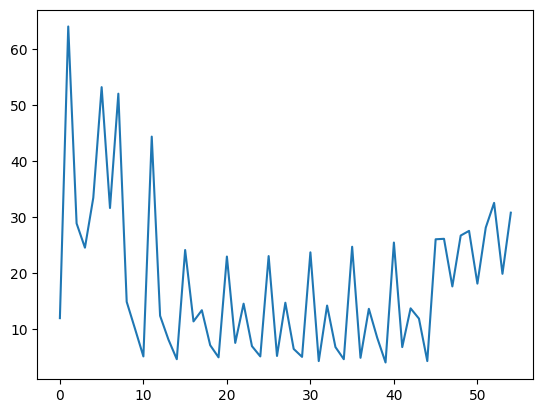

In [18]:
#this part is using the find_pulses to make an array of how long the gaps are between pulses, I believe?
#also note that this is in units of minutes, which makes sense with the plots above.

gaps=outils.find_pulses(np.asarray(num_sats_risen))
gaplen=[(gap[1]-gap[0])*5/60 for gap in gaps]
#print(gaplen)
print(np.median(gaplen), np.mean(gaplen))

plt.plot(gaplen)

{44387, 59051, 57166, 28654, 33591, 25338}
[44387 59051 57166 28654 33591 25338]
{0: np.int64(44387), np.int64(44387): 0, 1: np.int64(59051), np.int64(59051): 1, 2: np.int64(57166), np.int64(57166): 2, 3: np.int64(28654), np.int64(28654): 3, 4: np.int64(33591), np.int64(33591): 4, 5: np.int64(25338), np.int64(25338): 5}


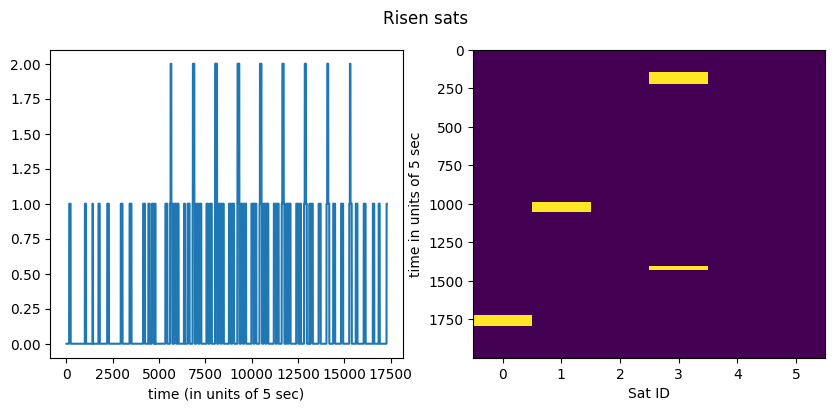

In [19]:
#here we start constructing the set of satellite numbers
satnums=[]
for s in rsats:
    if len(s)>0:
        for j in range(len(s)):
            satnums.append(s[j][0])

satids = set(satnums)
print(satids)
satlist = (np.array(list(satids)))
print(satlist)
satmap = {}
assert min(satlist) > len(
    satlist
)  # to make sure there are no collisions, we'll never have an i that's also a satnum
for i, satnum in enumerate(satlist):
    satmap[i] = satnum
    satmap[satnum] = i
arr = np.zeros((len(rsats), len(satlist)), dtype="int64")
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
fig.suptitle(f"Risen sats")
ax[0].plot(num_sats_risen)
ax[0].set_xlabel("time (in units of 5 sec)")
for i, row in enumerate(rsats):
    for satnum, satele,sataz in row:
        arr[i][satmap[satnum]] = 1
ax[1].set_ylabel("time in units of 5 sec")
ax[1].set_xlabel("Sat ID")
ax[1].imshow(arr[:2000],aspect='auto',interpolation="none")

print(satmap)

#On the left is just the number of risen sats, for all of the day

#On the right is which actual satellites are risen and for how long, for the first couple hours


In [20]:
m1=ant1.spec_num_start
m2=ant2.spec_num_start
print(m1,m2)

1295068843 1351312502


In [21]:
print(channels[ant1.channel_idxs])

[1834 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847
 1848 1849 1850 1851]


In [22]:
# freqs=outils.chan2freq(channels,alias=True)
# freqs=outils.chan2freq(np.asarray([1840,1844]),alias=True)
m1=ant1.spec_num_start
m2=ant2.spec_num_start
visibility_phased = np.zeros((nchunks,len(ant1.channel_idxs)), dtype='complex64')
st=time.time()
for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):
        # pol00[i,:] = cr.avg_xcorr_4bit_2ant(chunk1['pol0'], chunk2['pol0'],chnk1['specnums'],chunk2['specnums'],m1+i*acclen,m2+i*acclen)
        xcorr=avg_xcorr_4bit_2ant_float(chunk1['pol0'], chunk2['pol0'],chunk1['specnums'],chunk2['specnums'],m1+i*acclen,m2+i*acclen)
        visibility_phased[i,:] = np.sum(xcorr,axis=0)/acclen
        print("CHUNK", i, " has ", xcorr.shape[0], " rows")
print("Time taken final:", time.time()-st)
visibility_phased = np.ma.masked_invalid(visibility_phased)

CHUNK 0  has  30000  rows
CHUNK 1  has  30000  rows
CHUNK 2  has  30000  rows
CHUNK 3  has  30000  rows
CHUNK 4  has  30000  rows
CHUNK 5  has  30000  rows
CHUNK 6  has  30000  rows
CHUNK 7  has  30000  rows
CHUNK 8  has  30000  rows
CHUNK 9  has  30000  rows
CHUNK 10  has  30000  rows
CHUNK 11  has  30000  rows
CHUNK 12  has  30000  rows
CHUNK 13  has  30000  rows
CHUNK 14  has  30000  rows
CHUNK 15  has  30000  rows
CHUNK 16  has  30000  rows
CHUNK 17  has  30000  rows
CHUNK 18  has  30000  rows
CHUNK 19  has  30000  rows
CHUNK 20  has  30000  rows
CHUNK 21  has  30000  rows
CHUNK 22  has  30000  rows
CHUNK 23  has  30000  rows
CHUNK 24  has  30000  rows
CHUNK 25  has  30000  rows
CHUNK 26  has  30000  rows
took 1.436 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805018.raw
CHUNK 27  has  30000  rows
CHUNK 28  has  30000  rows
CHUNK 29  has  30000  rows
CHUNK 30  has  30000  rows
CHUNK 31  has  30000  rows
CHUNK 32  has  30000  rows
CHUNK 33  

[-0.304803    1.6098826   2.6857605  -2.03223     0.05961098  0.7467653
  1.8190362  -2.3879113   0.6217302  -2.3497705   1.3347     -0.21280004
  1.8554546   0.50893384 -0.78463304 -0.8990614  -1.5524871  -1.7109503 ]


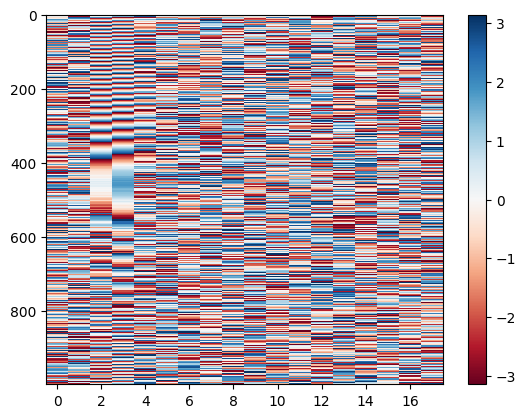

In [46]:
vis_phase = np.angle(visibility_phased)
print(vis_phase[0])
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:1000,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()


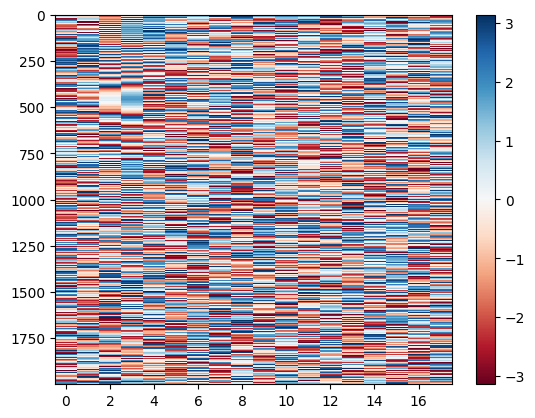

In [45]:
vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:2000,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

In [25]:
visibility_phased[:5,0]

masked_array(data=[(0.014833333902060986-0.004666666500270367j),
                   (0.01073333341628313-0.01626666635274887j),
                   (-0.025100000202655792-0.004800000227987766j),
                   (0.011066666804254055-0.02133333310484886j),
                   (0.014600000344216824-0.056433334946632385j)],
             mask=[False, False, False, False, False],
       fill_value=np.complex128(1e+20+0j),
            dtype=complex64)

In [26]:
t_start+3600*8.5

1721835602.0

/tmp/ipykernel_616778/4122049275.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(visibility_phased)), aspect='auto',interpolation="none")


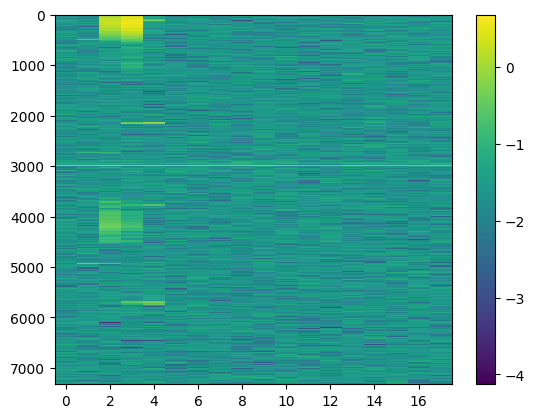

In [27]:
plt.imshow(np.log10(np.abs(visibility_phased)), aspect='auto',interpolation="none")
plt.colorbar()

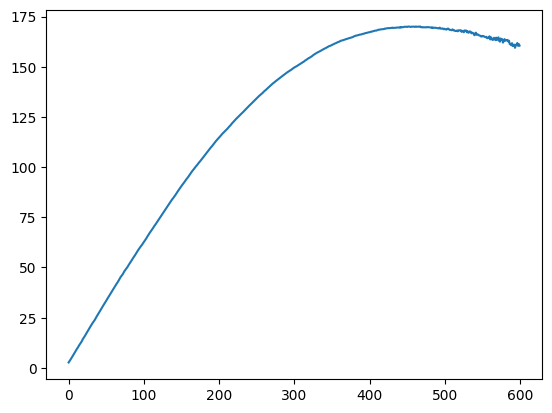

In [28]:
plt.plot(np.unwrap(vis_phase[0:600,2]))

In [29]:
d = outils.get_sat_delay(
                    a1_coords,
                    a2_coords,
                    tle_path,
                    t_start,
                    int(t_end-t_start)+1,
                    28654,
                )

catalog #28654 epoch 2024-07-24 20:56:55 UTC


In [30]:
delay = np.interp(
    np.arange(0, nchunks) * acclen * T_SPECTRA, np.arange(0, int(t_end-t_start)+1), d
)

In [31]:
delay.shape

(7324,)

In [32]:
channels[74]

np.int64(1836)

In [33]:
#THIS WAS NOAA 18

pred=(-delay[:600]+delay[0])*2*np.pi*outils.chan2freq(channels[74],alias=True)
obs=np.unwrap(vis_phase[:600,2])-vis_phase[0,2]

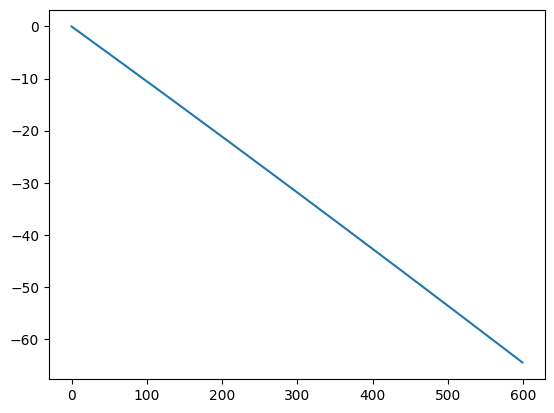

In [34]:
plt.plot(pred)
#plt.plot(obs)

catalog #59051 epoch 2024-07-24 21:55:34 UTC


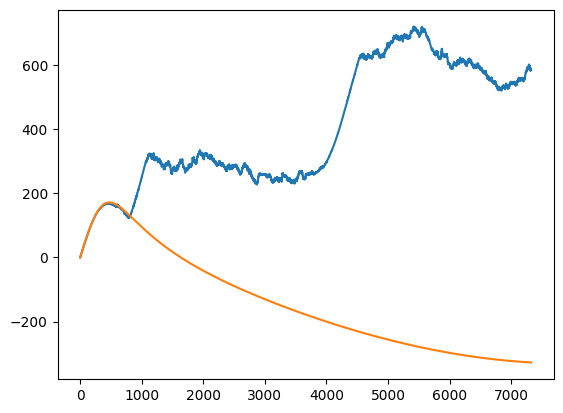

In [35]:
#THIS WAS METEOR2-4
d = outils.get_sat_delay(
                    a1_coords,
                    a2_coords,
                    tle_path,
                    t_start,
                    int(t_end-t_start)+1,
                    59051,
                )
delay = np.interp(
    np.arange(0, nchunks) * acclen * T_SPECTRA, np.arange(0, int(t_end-t_start)+1), d
)
# pred=(-delay[1000:4000]+delay[1000])*2*np.pi*outils.chan2freq(channels[74],alias=True)
pred=(-delay[:]+delay[0])*2*np.pi*outils.chan2freq(1837,alias=True)
obs=np.unwrap(vis_phase[:,3])-vis_phase[0,3]
plt.plot(obs)
plt.plot(pred)

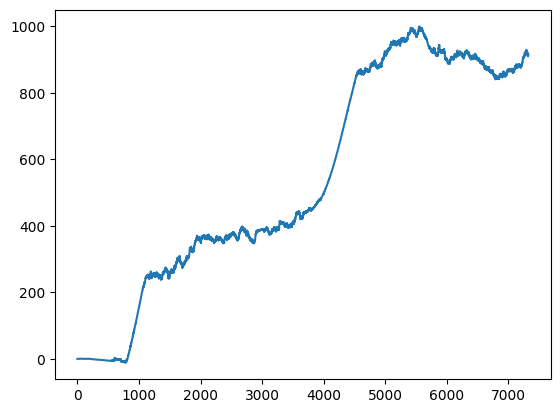

In [36]:
plt.plot(obs-pred) # a lot of this is probably inaccurate positions.

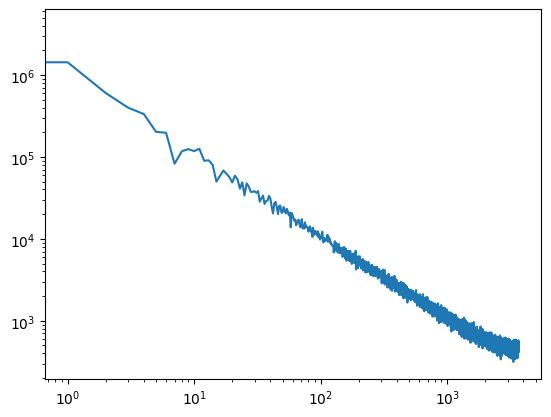

In [37]:
plt.loglog(np.abs(np.fft.rfft(obs-pred)))

In [38]:
outils.chan2freq(channels[74],alias=True)

np.float64(137939453.125)

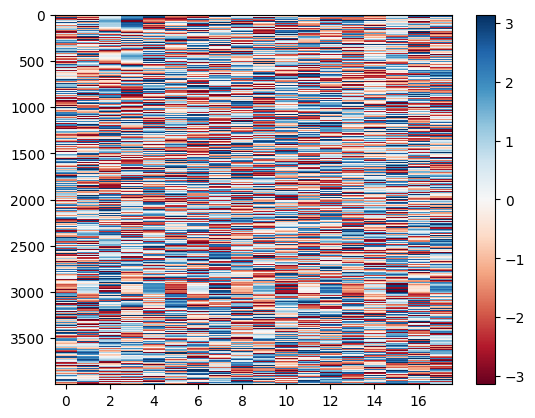

In [39]:
vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:4000], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

/tmp/ipykernel_616778/1085447008.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(visibility_phased[:,:40])), aspect='auto',interpolation="none")


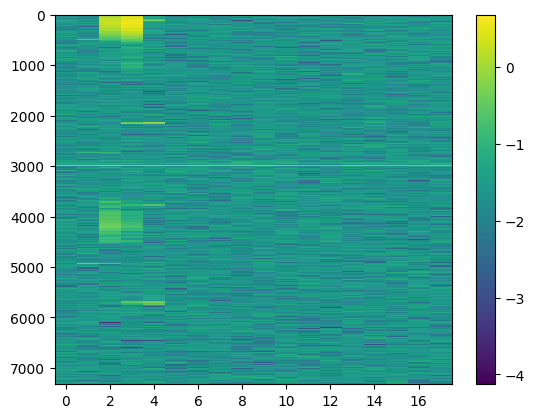

In [40]:
plt.imshow(np.log10(np.abs(visibility_phased[:,:40])), aspect='auto',interpolation="none")
plt.colorbar()